In [116]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import pickle
from sklearn.metrics import plot_confusion_matrix, classification_report
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, StandardScaler
from sklearn.tree import DecisionTreeClassifier, plot_tree
from imblearn.over_sampling import SMOTE
from sklearn.feature_selection import RFECV, VarianceThreshold
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.dummy import DummyClassifier
from imblearn.pipeline import Pipeline as imbpipeline

In [117]:
df=pd.read_pickle('data/cleaned_data')

In [123]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3081 entries, 0 to 3080
Data columns (total 32 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   SEASON        3081 non-null   object 
 1   AGE           3079 non-null   float64
 2   TEAM          3081 non-null   object 
 3   LEAGUE        3081 non-null   object 
 4   POS           2919 non-null   object 
 5   G             2867 non-null   float64
 6   GS            1865 non-null   float64
 7   MP            2695 non-null   float64
 8   FG            2866 non-null   float64
 9   FGA           2865 non-null   float64
 10  FG%           2851 non-null   float64
 11  3P            2139 non-null   float64
 12  3PA           2139 non-null   float64
 13  3P%           3081 non-null   float64
 14  2P            2336 non-null   float64
 15  2PA           2336 non-null   float64
 16  2P%           2316 non-null   float64
 17  eFG%          2323 non-null   float64
 18  FT            2866 non-null 

In [119]:
def missing(row): 
    if (row['3P%']==0):
        return 1
    else:
        return 0

In [53]:
df['missing']= df.apply(lambda row : missing(row), axis=1)

In [54]:
X=df.drop('target',axis=1)
y=df['target']

In [55]:
X_train,X_test,y_train,y_test = train_test_split(X,y, test_size=0.2,random_state=42, stratify=y)

In [56]:
cat_columns= [col for col in X.columns if X[col].dtype in ['object']]
num_columns = [col for col in X.columns if X[col].dtypes in ['float64', 'int64']]


In [57]:
zero_pipe=Pipeline(steps= [('imputer1',SimpleImputer(strategy='median')),
    ('ss', StandardScaler())
])

In [58]:
cat_pipe=Pipeline(steps= [('imputer',SimpleImputer(strategy='constant',fill_value='missing')),
    ('ohe', OneHotEncoder(sparse=False, handle_unknown='ignore'))
])

In [59]:
coltran= ColumnTransformer(transformers=[
    ('zero', zero_pipe , num_columns), 
    ('cat_pipe', cat_pipe, cat_columns)
],remainder= 'passthrough')


In [60]:
#preparing cleaned daatset for alll post modelin without cross val

In [61]:
coltran.fit(X_train)

ColumnTransformer(remainder='passthrough',
                  transformers=[('zero',
                                 Pipeline(steps=[('imputer1',
                                                  SimpleImputer(strategy='median')),
                                                 ('ss', StandardScaler())]),
                                 ['AGE', 'G', 'GS', 'MP', 'FG', 'FGA', 'FG%',
                                  '3P', '3PA', '3P%', '2P', '2PA', '2P%',
                                  'eFG%', 'FT', 'FTA', 'FT%', 'ORB', 'DRB',
                                  'TRB', 'AST', 'STL', 'BLK', 'TOV', 'PF',
                                  'PTS', 'SEASON_COUNT', 'missing']),
                                ('cat_pipe',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(fill_value='missing',
                                                                strategy='constant')),
                                        

In [62]:
X_cleaned_train= coltran.transform(X_train)

In [63]:
X_cleaned_test = coltran.transform(X_test)

In [64]:
#the order of the column name has to match the order of the column transformer
cat_columns = coltran.named_transformers_['cat_pipe']['ohe'].get_feature_names(cat_columns).tolist()
all_columns = num_columns + cat_columns 

cleaned_df_train = pd.DataFrame(X_cleaned_train, columns=all_columns)
cleaned_df_test = pd.DataFrame(X_cleaned_test, columns=all_columns)

In [65]:
cleaned_df_train[num_columns].describe()

,AGE,G,GS,MP,FG,FGA,FG%,3P,3PA,3P%,...,DRB,TRB,AST,STL,BLK,TOV,PF,PTS,SEASON_COUNT,missing
count,2.464000e+03,2.464000e+03,2.464000e+03,2.464000e+03,2.464000e+03,2.464000e+03,2.464000e+03,2.464000e+03,2.464000e+03,2.464000e+03,...,2.464000e+03,2.464000e+03,2.464000e+03,2.464000e+03,2.464000e+03,2.464000e+03,2.464000e+03,2.464000e+03,2464.0,2.464000e+03
mean,-5.736978e-17,5.046468e-17,-5.528586e-17,7.682347e-17,-9.439599e-18,1.910449e-17,7.069111e-16,1.258012e-16,1.714898e-16,-3.561365e-16,...,-1.387328e-16,-1.637849e-16,-1.007491e-16,-3.054916e-17,-6.778939e-17,1.974431e-16,-3.936921e-18,1.065841e-16,0.0,-1.580626e-16
std,1.000203e+00,1.000203e+00,1.000203e+00,1.000203e+00,1.000203e+00,1.000203e+00,1.000203e+00,1.000203e+00,1.000203e+00,1.000203e+00,...,1.000203e+00,1.000203e+00,1.000203e+00,1.000203e+00,1.000203e+00,1.000203e+00,1.000203e+00,1.000203e+00,0.0,1.000203e+00
min,-3.917032e+00,-1.877664e+00,-6.840750e-01,-2.072285e+00,-1.410857e+00,-1.531462e+00,-4.237336e+00,-5.952722e-01,-6.619943e-01,-7.579977e-01,...,-1.489566e+00,-1.336365e+00,-1.072487e+00,-1.550149e+00,-8.532358e-01,-1.680478e+00,-2.234829e+00,-1.410434e+00,0.0,-1.152789e+00
25%,-6.892631e-01,-8.606296e-01,-5.566641e-01,-7.581134e-01,-7.469581e-01,-7.501724e-01,-3.420862e-01,-5.952722e-01,-5.803795e-01,-7.579977e-01,...,-6.172155e-01,-6.309583e-01,-6.519382e-01,-6.067549e-01,-6.341930e-01,-5.935025e-01,-7.341835e-01,-7.317489e-01,0.0,-1.152789e+00
50%,-1.513017e-01,2.694082e-01,-4.292533e-01,-8.049398e-02,-2.158390e-01,-2.011583e-01,9.402321e-02,-3.745755e-01,-4.171498e-01,-7.579977e-01,...,-1.810401e-01,-2.429846e-01,-2.914679e-01,-1.350578e-01,-1.961073e-01,-1.858866e-01,1.613925e-02,-2.227349e-01,0.0,8.674614e-01
75%,3.866598e-01,9.097630e-01,-7.887339e-02,7.613969e-01,5.365797e-01,5.590150e-01,4.904863e-01,6.681810e-02,1.541540e-01,9.246107e-01,...,2.551353e-01,3.566112e-01,3.693943e-01,3.366393e-01,2.293549e-02,3.576014e-01,6.592731e-01,5.407860e-01,0.0,8.674614e-01
max,5.766274e+00,1.361778e+00,2.798489e+00,2.907192e+00,7.441128e+00,6.809329e+00,5.674241e+00,6.687721e+00,6.438496e+00,4.740722e+00,...,6.361591e+00,7.728111e+00,5.896606e+00,5.997005e+00,1.141316e+01,4.977249e+00,2.910241e+00,7.141000e+00,0.0,8.674614e-01


In [66]:
#with open('cleaned_df_test.pkl', "wb") as f:
    #pickle.dump(cleaned_df_test , f)
    
#with open('cleaned_df_train.pkl', "wb") as f1:
    #pickle.dump(cleaned_df_train, f1)

#with open('y_train.pkl', "wb") as f3:
    #pickle.dump(y_train, f3)

#with open('y_test.pkl', "wb") as f4:
    #pickle.dump(y_test, f4)

In [67]:
dummy_clf = DummyClassifier(strategy="most_frequent")
dummy_clf.fit(cleaned_df_train, y_train)
dummy_clf.score(cleaned_df_train, y_train)

0.9253246753246753

In [68]:
def evaluate_model(model, X, y):
    y_pred = model.predict(X)
    print(classification_report(y, y_pred))
    plot_confusion_matrix(model, X, y,cmap="Blues")

In [69]:
dt_pipe= Pipeline(steps= [('col', coltran), ('dt',DecisionTreeClassifier())])

In [70]:
dt_pipe.fit(X_train, y_train)


Pipeline(steps=[('col',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('zero',
                                                  Pipeline(steps=[('imputer1',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('ss',
                                                                   StandardScaler())]),
                                                  ['AGE', 'G', 'GS', 'MP', 'FG',
                                                   'FGA', 'FG%', '3P', '3PA',
                                                   '3P%', '2P', '2PA', '2P%',
                                                   'eFG%', 'FT', 'FTA', 'FT%',
                                                   'ORB', 'DRB', 'TRB', 'AST',
                                                   'STL', 'BLK', 'TOV', 'PF',
                                           

In [71]:
score= cross_val_score(dt_pipe, X_train, y_train)

In [72]:
score.mean()

0.9078752947772883

In [73]:
dt_pipe.score(X_test, y_test)


0.9141004862236629

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      2280
           1       1.00      0.99      1.00       184

    accuracy                           1.00      2464
   macro avg       1.00      1.00      1.00      2464
weighted avg       1.00      1.00      1.00      2464



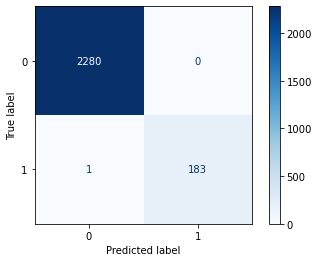

In [74]:

evaluate_model(dt_pipe, X_train, y_train)

              precision    recall  f1-score   support

           0       0.95      0.96      0.95       571
           1       0.41      0.37      0.39        46

    accuracy                           0.91       617
   macro avg       0.68      0.66      0.67       617
weighted avg       0.91      0.91      0.91       617



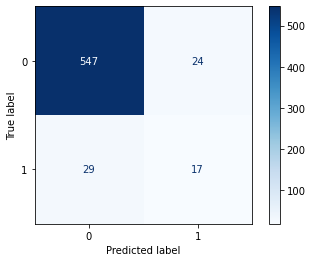

In [75]:
evaluate_model(dt_pipe, X_test, y_test)


In [76]:
#SMOTE PLUS DECISION TREE MODEL

In [77]:
pipe_model = imbpipeline(steps=[
    ('col', coltran),
    ('smote', SMOTE()),
    ('dt', DecisionTreeClassifier())
])

In [78]:
pipe_model.fit(X_train, y_train)


Pipeline(steps=[('col',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('zero',
                                                  Pipeline(steps=[('imputer1',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('ss',
                                                                   StandardScaler())]),
                                                  ['AGE', 'G', 'GS', 'MP', 'FG',
                                                   'FGA', 'FG%', '3P', '3PA',
                                                   '3P%', '2P', '2PA', '2P%',
                                                   'eFG%', 'FT', 'FTA', 'FT%',
                                                   'ORB', 'DRB', 'TRB', 'AST',
                                                   'STL', 'BLK', 'TOV', 'PF',
                                           

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      2280
           1       1.00      0.99      1.00       184

    accuracy                           1.00      2464
   macro avg       1.00      1.00      1.00      2464
weighted avg       1.00      1.00      1.00      2464



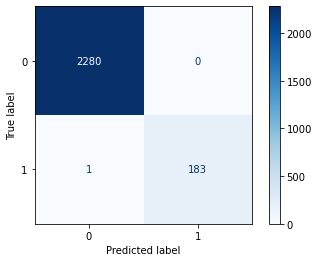

In [79]:
evaluate_model(pipe_model, X_train, y_train)


              precision    recall  f1-score   support

           0       0.95      0.93      0.94       571
           1       0.32      0.39      0.35        46

    accuracy                           0.89       617
   macro avg       0.64      0.66      0.65       617
weighted avg       0.90      0.89      0.90       617



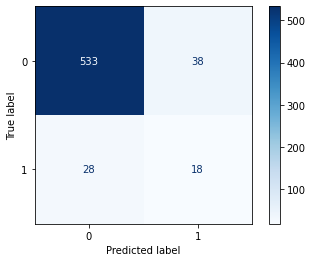

In [80]:
evaluate_model(pipe_model, X_test, y_test)


In [81]:
#Grid Search and smote 

In [83]:
param_grid = {'dt__criterion' :['gini', 'entropy'],
    'dt__max_depth': [None, 5, 9]
}

grid = GridSearchCV(pipe_model, param_grid, scoring='f1', verbose=2)
grid.fit(X_train, y_train)

grid.best_params_

Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV] dt__criterion=gini, dt__max_depth=None ..........................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] ........... dt__criterion=gini, dt__max_depth=None, total=   0.3s
[CV] dt__criterion=gini, dt__max_depth=None ..........................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s remaining:    0.0s


[CV] ........... dt__criterion=gini, dt__max_depth=None, total=   0.3s
[CV] dt__criterion=gini, dt__max_depth=None ..........................
[CV] ........... dt__criterion=gini, dt__max_depth=None, total=   0.3s
[CV] dt__criterion=gini, dt__max_depth=None ..........................
[CV] ........... dt__criterion=gini, dt__max_depth=None, total=   0.3s
[CV] dt__criterion=gini, dt__max_depth=None ..........................
[CV] ........... dt__criterion=gini, dt__max_depth=None, total=   0.3s
[CV] dt__criterion=gini, dt__max_depth=5 .............................
[CV] .............. dt__criterion=gini, dt__max_depth=5, total=   0.1s
[CV] dt__criterion=gini, dt__max_depth=5 .............................
[CV] .............. dt__criterion=gini, dt__max_depth=5, total=   0.1s
[CV] dt__criterion=gini, dt__max_depth=5 .............................
[CV] .............. dt__criterion=gini, dt__max_depth=5, total=   0.1s
[CV] dt__criterion=gini, dt__max_depth=5 .............................
[CV] .

[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:    5.8s finished


{'dt__criterion': 'entropy', 'dt__max_depth': 9}

In [84]:
pd.DataFrame(grid.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_dt__criterion,param_dt__max_depth,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.270972,0.012496,0.009881,0.007919,gini,None,"{'dt__criterion': 'gini', 'dt__max_depth': None}",0.405797,0.373626,0.387755,0.409639,0.302326,0.375829,0.038964,5
1,0.127022,0.006008,0.009834,0.006442,gini,5,"{'dt__criterion': 'gini', 'dt__max_depth': 5}",0.426230,0.468468,0.390625,0.471698,0.406780,0.432760,0.032509,2
2,0.164742,0.011593,0.012494,0.006247,gini,9,"{'dt__criterion': 'gini', 'dt__max_depth': 9}",0.446809,0.431373,0.382609,0.475248,0.423077,0.431823,0.030361,3
3,0.210965,0.015802,0.010269,0.005848,entropy,None,"{'dt__criterion': 'entropy', 'dt__max_depth': ...",0.390244,0.326531,0.373333,0.341463,0.384615,0.363237,0.024939,6
4,0.147972,0.005670,0.006250,0.007655,entropy,5,"{'dt__criterion': 'entropy', 'dt__max_depth': 5}",0.406250,0.391304,0.453782,0.446429,0.400000,0.419553,0.025500,4
5,0.181735,0.011641,0.012515,0.006258,entropy,9,"{'dt__criterion': 'entropy', 'dt__max_depth': 9}",0.421053,0.444444,0.457831,0.442105,0.415842,0.436255,0.015586,1


In [85]:
best_model = grid.best_estimator_
best_model.fit(X_train, y_train)

Pipeline(steps=[('col',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('zero',
                                                  Pipeline(steps=[('imputer1',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('ss',
                                                                   StandardScaler())]),
                                                  ['AGE', 'G', 'GS', 'MP', 'FG',
                                                   'FGA', 'FG%', '3P', '3PA',
                                                   '3P%', '2P', '2PA', '2P%',
                                                   'eFG%', 'FT', 'FTA', 'FT%',
                                                   'ORB', 'DRB', 'TRB', 'AST',
                                                   'STL', 'BLK', 'TOV', 'PF',
                                           

              precision    recall  f1-score   support

           0       0.96      0.92      0.94       571
           1       0.33      0.50      0.40        46

    accuracy                           0.89       617
   macro avg       0.65      0.71      0.67       617
weighted avg       0.91      0.89      0.90       617



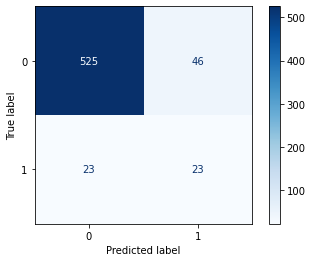

In [86]:

evaluate_model(best_model, X_test, y_test)

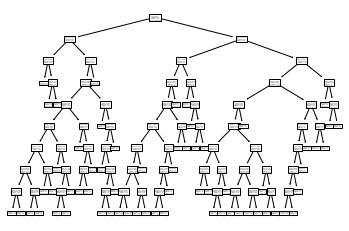

In [87]:

fig, axes = plt.subplots()
plot_tree(best_model['dt'])
plt.show()

In [88]:
#top features forr decision tree and smote 

In [89]:
cat_columns= [col for col in X.columns if X[col].dtype in ['object']]

cat_ohe_cols = best_model.named_steps['col'].named_transformers_['cat_pipe']['ohe'].get_feature_names(cat_columns).tolist()

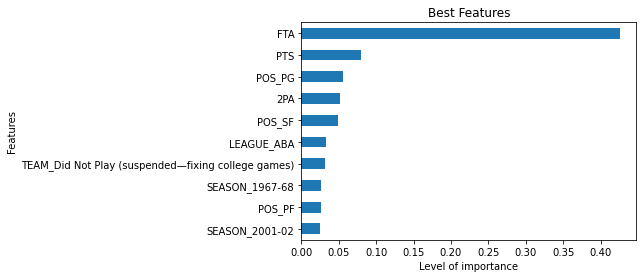

In [90]:
feat_cols = num_columns+ cat_ohe_cols 

X_train_tf = pd.DataFrame(best_model.named_steps['col'].fit_transform(X_train), columns=all_columns)


important_feats = pd.Series(best_model.named_steps['dt'].feature_importances_, 
                           index=feat_cols)

important_feats.sort_values(ascending=False)[:5]

top_feats = important_feats.sort_values(ascending=False).head(10)
plt.Figure(figsize=(5, 5))
top_feats.sort_values().plot(kind='barh')
plt.xlabel('Level of importance')
plt.ylabel('Features')
plt.title('Best Features');


In [91]:
#feature selection 

In [92]:

threshold_ranges= np.linspace(0,1, num=6)

for thresh in threshold_ranges:
    selector = VarianceThreshold(thresh)
    reduce_featrue_train= selector.fit_transform(cleaned_df_train)
    reduce_featrue_test= selector.transform(cleaned_df_test)
    base2 = DecisionTreeClassifier()
    base2.fit(reduce_featrue_train, y_train)
    print(base2.score(reduce_featrue_train, y_train))
    print(base2.score(reduce_featrue_test, y_test))
    print("\n")

0.9995941558441559
0.9173419773095624


0.9987824675324676
0.9141004862236629


0.9987824675324676
0.9189627228525121


0.9987824675324676
0.9173419773095624


0.9987824675324676
0.9205834683954619


0.9987824675324676
0.9141004862236629




In [93]:
cleaned_df_train[cleaned_df_train.columns[selector.get_support(indices=True)]]

,AGE,G,GS,MP,FGA,FG%,3P,2PA,FT,FT%,TRB,TOV,PTS
0,-0.689263,-0.822962,-0.641605,-0.460372,-0.539013,-0.084385,0.287515,-0.512282,-0.545519,0.603747,-1.018932,-1.408734,-0.511176
1,0.386660,0.947431,0.335212,-0.224231,-0.285622,0.252608,-0.595272,-0.013827,-0.825625,-0.634611,0.391881,-0.321759,-0.409373
2,-0.689263,0.005733,1.014736,0.268583,0.347856,-0.074474,1.170302,0.160632,-0.055333,1.014001,-0.278255,0.221729,0.269312
3,0.386660,-1.802328,-0.429253,-1.322796,-1.256955,0.718453,-0.595272,-1.110428,-0.685572,-2.898603,-0.877851,-0.321759,-1.071092
4,-2.303147,0.269408,-0.429253,-0.080494,-0.201158,0.094023,-0.374575,-0.263054,-0.265413,0.155507,-0.242985,-0.185887,-0.222735
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2459,2.538505,0.985099,-0.429253,1.664889,2.459448,-0.104208,2.494483,2.378757,2.955806,1.348281,-0.207714,2.123937,2.508973
2460,0.924621,0.533084,-0.684075,-0.891584,-0.560129,0.222874,1.170302,-0.761509,-0.405466,0.808874,-0.772040,-0.729375,-0.392406
2461,-0.689263,-0.672290,0.335212,0.689528,0.390088,0.995977,0.287515,0.534474,0.014693,-0.824543,1.026748,-0.185887,0.574720
2462,0.924621,-1.011301,-0.429253,0.689528,0.812406,-0.252882,-0.595272,1.282156,1.275170,0.466996,-0.207714,2.803297,0.693490


In [94]:
#tree pruning and variance threshold data 

In [95]:

clf = DecisionTreeClassifier()

In [96]:
path = clf.cost_complexity_pruning_path(reduce_featrue_train, y_train)

In [97]:
ccp_alphas = path.ccp_alphas

In [98]:
ccp_alphas = ccp_alphas[:-1]


In [99]:
clfs= []


In [100]:
for ccp_alpha in ccp_alphas: 
    clf =DecisionTreeClassifier(random_state =0, ccp_alpha= ccp_alpha)
    clf.fit(reduce_featrue_train, y_train)
    clfs.append(clf)
print("Number of nodes in the last tree is: {} with ccp_alpha: {}".format(clfs[-1].tree_.node_count, ccp_alphas[-1]))

Number of nodes in the last tree is: 3 with ccp_alpha: 0.0039780341823630605


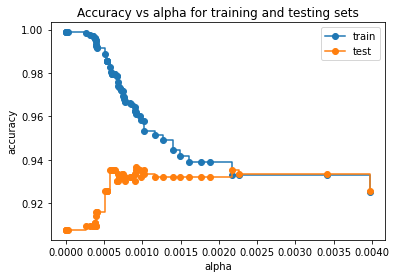

In [101]:
train_scores = [clf.score(reduce_featrue_train, y_train) for clf in clfs]
test_scores = [clf.score(reduce_featrue_test, y_test) for clf in clfs]

fig, ax = plt.subplots()
ax.set_xlabel("alpha")
ax.set_ylabel("accuracy")
ax.set_title("Accuracy vs alpha for training and testing sets")
ax.plot(ccp_alphas, train_scores, marker='o', label="train",
        drawstyle="steps-post")
ax.plot(ccp_alphas, test_scores, marker='o', label="test",
        drawstyle="steps-post")
ax.legend()
plt.show()

In [102]:
clf_pruned = DecisionTreeClassifier(random_state = 42, ccp_alpha= 0.0020)
clf_pruned = clf_pruned.fit(reduce_featrue_train, y_train)

              precision    recall  f1-score   support

           0       0.94      1.00      0.97       571
           1       1.00      0.15      0.26        46

    accuracy                           0.94       617
   macro avg       0.97      0.58      0.62       617
weighted avg       0.94      0.94      0.91       617



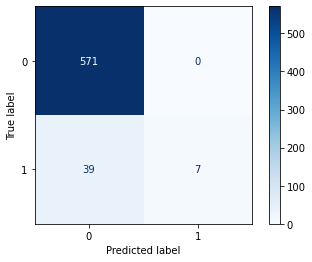

In [103]:
evaluate_model(clf_pruned,reduce_featrue_test, y_test)


              precision    recall  f1-score   support

           0       0.94      1.00      0.97      2280
           1       0.94      0.16      0.28       184

    accuracy                           0.94      2464
   macro avg       0.94      0.58      0.62      2464
weighted avg       0.94      0.94      0.92      2464



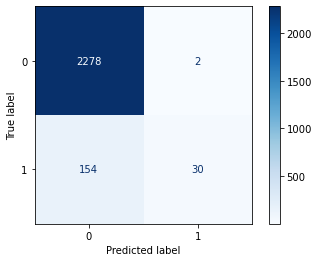

In [104]:
evaluate_model(clf_pruned,reduce_featrue_train, y_train)


In [105]:

#pipeline - decision tree
tree_pipe = imbpipeline(steps=[
    ('coltran', coltran),
    ('smote', SMOTE()),
    ('tree', DecisionTreeClassifier())
])

#decision tree baseline model
%time
tree_pipe.fit(X_train, y_train)
tree_pipe.score(X_train, y_train)


Wall time: 0 ns


0.9995941558441559

              precision    recall  f1-score   support

           0       0.96      0.91      0.93       571
           1       0.32      0.50      0.39        46

    accuracy                           0.88       617
   macro avg       0.64      0.71      0.66       617
weighted avg       0.91      0.88      0.89       617



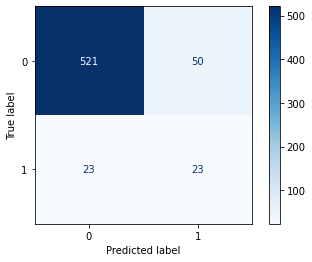

In [106]:
evaluate_model(tree_pipe, X_test, y_test)


In [107]:
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
#pipeline - random forest
forest_pipe = imbpipeline(steps=[
    ('coltran', coltran),
    ('smote', SMOTE()),
    ('forest', RandomForestClassifier())
])

#random forest baseline model
%time
forest_pipe.fit(X_train, y_train)
forest_pipe.score(X_train, y_train)

Wall time: 0 ns


0.9995941558441559

              precision    recall  f1-score   support

           0       0.96      0.96      0.96       571
           1       0.55      0.52      0.53        46

    accuracy                           0.93       617
   macro avg       0.75      0.74      0.75       617
weighted avg       0.93      0.93      0.93       617



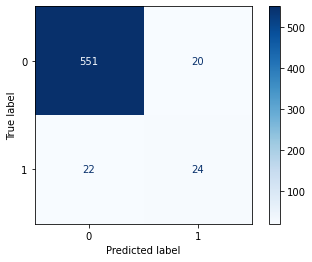

In [108]:

evaluate_model(forest_pipe, X_test, y_test)


In [109]:
#pipeline - xg boosting
from xgboost import XGBClassifier
xg_pipe = imbpipeline(steps=[
    ('coltran', coltran),
    ('smote', SMOTE()),
    ('xg', XGBClassifier())
])

#xg boosting baseline model
%time
xg_pipe.fit(X_train, y_train)
xg_pipe.score(X_train, y_train)

Wall time: 0 ns


0.9995941558441559

              precision    recall  f1-score   support

           0       0.96      0.97      0.97       571
           1       0.62      0.54      0.58        46

    accuracy                           0.94       617
   macro avg       0.79      0.76      0.78       617
weighted avg       0.94      0.94      0.94       617



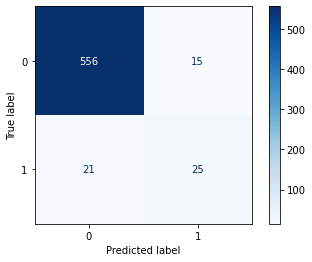

In [110]:
evaluate_model(xg_pipe, X_test, y_test)


In [111]:

#pipeline - gradient boosting
gb_pipe = imbpipeline(steps=[
    ('coltran', coltran),
    ('smote', SMOTE()),
    ('gb', GradientBoostingClassifier())
])

#gradient boosting baseline model
%time
gb_pipe.fit(X_train, y_train)
gb_pipe.score(X_train, y_train)

Wall time: 0 ns


0.942775974025974

              precision    recall  f1-score   support

           0       0.97      0.95      0.96       571
           1       0.52      0.70      0.60        46

    accuracy                           0.93       617
   macro avg       0.75      0.82      0.78       617
weighted avg       0.94      0.93      0.93       617



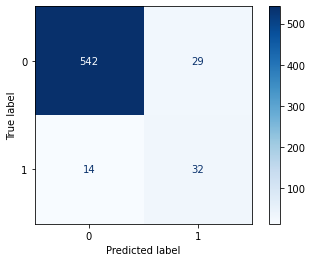

In [112]:
evaluate_model(gb_pipe, X_test, y_test)


In [113]:

#random forest grid 1
forest_param_grid1 = {
    'forest__max_depth': [20, 30],
    'forest__min_samples_split': [2, 3, 5],
    'forest__min_samples_leaf': [1, 2]
}

gs_forest1 = GridSearchCV(forest_pipe, forest_param_grid1, cv=2)

%time
gs_forest1.fit(X_train, y_train)

gs_forest1.best_params_

Wall time: 0 ns


{'forest__max_depth': 30,
 'forest__min_samples_leaf': 1,
 'forest__min_samples_split': 5}

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      2280
           1       1.00      0.99      1.00       184

    accuracy                           1.00      2464
   macro avg       1.00      1.00      1.00      2464
weighted avg       1.00      1.00      1.00      2464



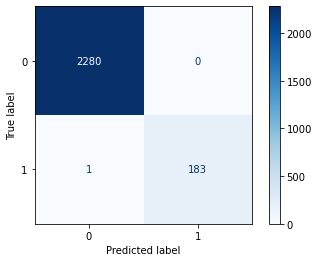

In [114]:
#classification report
evaluate_model(gs_forest1.best_estimator_, X_train, y_train)

              precision    recall  f1-score   support

           0       0.96      0.96      0.96       571
           1       0.50      0.50      0.50        46

    accuracy                           0.93       617
   macro avg       0.73      0.73      0.73       617
weighted avg       0.93      0.93      0.93       617



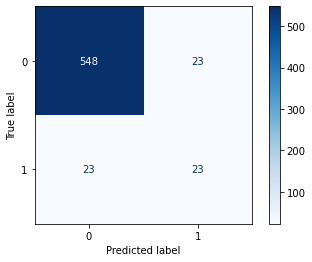

In [115]:
evaluate_model(gs_forest1.best_estimator_, X_test, y_test)